In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
script_dir = os.getcwd()
data_dir = os.path.join(script_dir, 'data')
data = []

categories = os.listdir(data_dir)
for i, category in enumerate(categories):
    category_dir = os.path.join(data_dir, category)
    for img in os.listdir(category_dir):
        img_path = os.path.join(category_dir, img)
        img_data = cv2.imread(img_path)
        img_data = cv2.resize(img_data, (256, 256))
        data.append([img_data, i])
    print(f"Loaded {len(os.listdir(category_dir))} images from {category_dir}")

Loaded 1500 images from c:\Users\Seifl\Documents\Robotics\MA4\Swisscom\data\cloudy
Loaded 1131 images from c:\Users\Seifl\Documents\Robotics\MA4\Swisscom\data\desert
Loaded 1500 images from c:\Users\Seifl\Documents\Robotics\MA4\Swisscom\data\green_area
Loaded 1500 images from c:\Users\Seifl\Documents\Robotics\MA4\Swisscom\data\water


In [3]:
np.random.shuffle(data)
images, labels = zip(*data)
images = np.array(images)
labels = np.array(labels)

# Normalize the images
images = images.astype('float32') / 255.0

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [4]:
# Flatten the images for KNN
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [5]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(X_train_flat, y_train)
y_pred = knn.predict(X_test_flat)

print("KNN Algorithm with 50 neighbors")

knn_accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Accuracy: {knn_accuracy * 100:.2f}%")

d:\Anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\Anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "d:\Anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "d:\Anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^

KNN Algorithm with 50 neighbors
KNN Accuracy: 89.44%


Confusion Matrix for KNN:
[[319   4   3  11]
 [  8 205   0   0]
 [  0   0 226  63]
 [  4   0  26 258]]


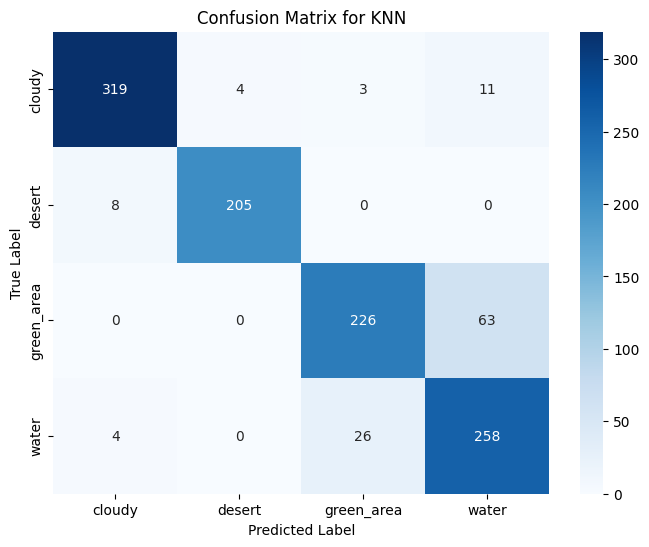

In [6]:
cm_knn = confusion_matrix(y_test, y_pred)
print("Confusion Matrix for KNN:")
print(cm_knn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix for KNN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [13]:
X_val_cnn, X_test_cnn, y_val_cnn, y_test_cnn = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

X_val_cnn = torch.tensor(X_val_cnn).permute(0, 3, 1, 2)
X_test_cnn = torch.tensor(X_test_cnn).permute(0, 3, 1, 2)
X_train_cnn = torch.tensor(X_train).permute(0, 3, 1, 2)
y_train_cnn = torch.tensor(y_train, dtype=torch.long)
y_val_cnn = torch.tensor(y_val_cnn, dtype=torch.long)
y_test_cnn = torch.tensor(y_test_cnn, dtype=torch.long)

train_dataset = DataLoader(TensorDataset(X_train_cnn, y_train_cnn), batch_size=32, shuffle=True)
val_dataset = DataLoader(TensorDataset(X_val_cnn, y_val_cnn), batch_size=32, shuffle=False)
test_dataset = DataLoader(TensorDataset(X_test_cnn, y_test_cnn), batch_size=32, shuffle=False)

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 64 * 64, 64)
        self.fc2 = nn.Linear(64, len(categories))
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
        train_accuracy = train_correct / train_total
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss / len(train_loader):.4f}, Accuracy: {train_accuracy:.4f}")

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
            val_accuracy = val_correct / val_total
            print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.4f}")

In [16]:
def test_model(model, test_loader, criterion):
    model.eval()
    test_loss, test_correct, test_total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    test_accuracy = test_correct / test_total
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy:.4f}")

    return all_preds, all_labels

In [17]:
device = torch.device("cpu")

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

In [18]:
train_model(model, train_dataset, val_dataset, criterion, optimizer, num_epochs)
y_pred_cnn, y_true_cnn = test_model(model, test_dataset, criterion)

Epoch [1/10], Loss: 0.9946, Accuracy: 0.5662
Validation Loss: 0.4564, Validation Accuracy: 0.8117
Epoch [2/10], Loss: 0.6136, Accuracy: 0.6694
Validation Loss: 0.5533, Validation Accuracy: 0.6554
Epoch [3/10], Loss: 0.5644, Accuracy: 0.7103
Validation Loss: 0.3545, Validation Accuracy: 0.8703
Epoch [4/10], Loss: 0.4843, Accuracy: 0.7897
Validation Loss: 0.3368, Validation Accuracy: 0.8881
Epoch [5/10], Loss: 0.4559, Accuracy: 0.8102
Validation Loss: 0.2397, Validation Accuracy: 0.9041
Epoch [6/10], Loss: 0.4415, Accuracy: 0.8097
Validation Loss: 0.2847, Validation Accuracy: 0.8810
Epoch [7/10], Loss: 0.4272, Accuracy: 0.8133
Validation Loss: 0.2736, Validation Accuracy: 0.8757
Epoch [8/10], Loss: 0.3935, Accuracy: 0.8353
Validation Loss: 0.2887, Validation Accuracy: 0.8952
Epoch [9/10], Loss: 0.3717, Accuracy: 0.8399
Validation Loss: 0.2301, Validation Accuracy: 0.9254
Epoch [10/10], Loss: 0.3857, Accuracy: 0.8428
Validation Loss: 0.2202, Validation Accuracy: 0.9236
Test Loss: 0.2616, 

Confusion Matrix for CNN:
[[153  22   1   0]
 [  1  98   0   0]
 [  0   0 129  14]
 [  1   0  31 114]]


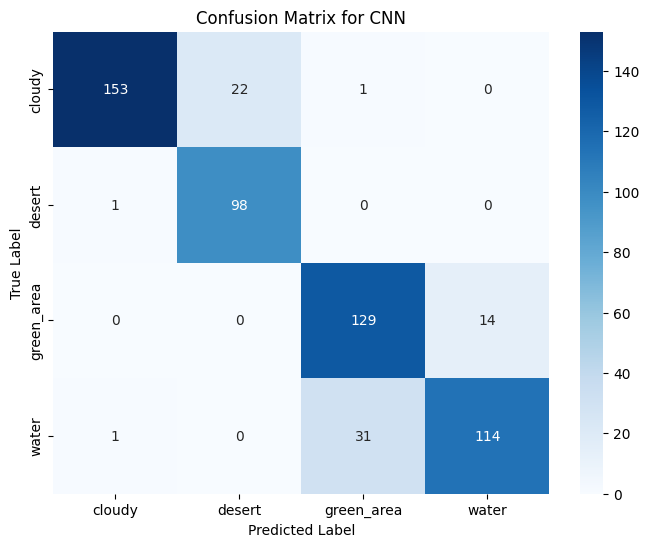

In [19]:
cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)
print("Confusion Matrix for CNN:")
print(cm_cnn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix for CNN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

To give an explanation of the simple baseline I chose, I had a lot of choices and drafts in [this repo](https://github.com/SeifLabib/swisscom-cv), which had relatively good results, for example a SVM, or even logistic regression.

Logistic regression was not at all a good choice, since first of all it did not converge in 1000 iterations, and its results are unexpected, we can never guarantee it giving good or bad predictions.
An SVM was not at all a bad choice, but its only problem is the fact that it took so much time to fit the training set, however, is low training time a criterion we have to satisfy? I don't think so, normally it is just low inference/prediction time for embedded systems/constrained environments. So at the end, having taken an hour to fit the set, I decided to take kNN, with 50 neighbors, since it gave the best results, and being so fast compared to SVM and having the dataset as simple as the one we have. In almost all other cases I would have not chosen kNN as a simple baseline algorithm.

To give explanation of this deep learning model I used. All draft done is in the [repo]((https://github.com/SeifLabib/swisscom-cv)). My initial thought for the deep learning model is the fact that the more convolutional layers we add to a CNN, the more they extract minute details and analyze them to learn. However, I took a look at the dataset, the images were all "simple", nothing had real details to be analyzed to be able to classify, so my instant idea was to only use two convolutional layers, which at the end worked, since when I added a third one, the performance was much worse (about 40% accuracy). The other idea was to have a transformer in the CNN, which was also an overkill, since the images are so simple and the transformer add so much time, without really analyzing anything more than the two-layer network does. That's why I stuck to the two-layer network, giving us relatively good results. 
Other than that, the network was just simple, let's say 'default' two convolutional layers, each followed by a max pooling layer, and then one fully connected layers, but followed by a 50% dropout layer, to decrease the possibility of overfitting, since in mind I wanted 10 epochs for training (even though the dataset is much simpler that that), and then another fully connected layer to give the output (prediction).


Another thing I had in mind, which is why I decided to plot the confusion matrix, is the fact where what is really our priority, what class would we want to get all true positives, even if at the cost of more false negatives?
This is another question I have to ask to get more context for everything to be well suited for the application in hands.


To answer the questions you asked me: 

- Are there any pairs of images that are more complicated to distinguish than others? 

If I understood the question correctly, well the answer is yes, looking at the confusion matrices of both models, green area and water were a pair of classes that were a bit hard to distinguish, more than any other pair of classes. Well it does make sense, if we look at the images, a lot of images from both classes almost have the same shade, green area has a lot of 'blue' images. That's why it is clear in both confusion matrices that the models find it hard to distinguish between both classes. Also , texture differences may not (are most probably not) apparent in the images. From a technical point of view, it is most probable that for both the simple baseline and the deep learning model, the features of both classes are overlapping, without advanced feature extraction or higher-dimensional characteristics, the problem will still persist for this dataset quality.


- What would you change in your approach if you had to perform the classification in a constrained environment, e.g., on limited hardware?

As I said, on limited hardware, the most important thing is the inference/prediction time, we don't really care about training time. So this will be the first objective, have a quick model. Next goal would be the priority problem I mentioned, what do we absolutely want, what can we "sacrifice" for it, meaning for example, if the model finds it hard to disitinguish between two classes, then the default would be to predict water, because "better safe than sorry", since then the application will be more "concrete".

So honestly I would quantize & compress the deep learning model we have, to be faster (although it is already lightweight), I would also reduce its complexity, the number of filters (kernels) in the convolutional layers, reduce also the number of neurons would help with lowering memory & computation requirements. I would even implement the kNN algorithm on the hardware, since it is fast enough & precise enough, but with reduced dimensionality-dataset (perform PCA before classification), which would also decrease memory usage, and make distance computation faster.

For both models I can also increase the size of batches being processed. I can also decrease the image quality (since I set it to 256x256), it can be decrease to (64x64 since two classes were originally this quality), or even less.

Although honestly, the training set itself can surely be bettered, the image lightning and clarity would very much help the model (more complex) and the algorithm, both being able to achieve better accuracy.